### Semi-Topological Codes
* Construction based off of https://arxiv.org/abs/2005.07016

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import galois

In [2]:
def tanner_to_parity_check_mat(G: nx.Graph) -> np.array:
    """
    Converts Tanner graph 'G' into parity check matrix

    Parameters:
    -----------
    G - Tanner graph
    """
    num_var_nodes = 0
    num_check_nodes = 0
    check_node_list = []
    G_nodes = list(G.nodes)
    G_edges = list(G.edges)
    for node in G_nodes:
        if (node[0] == 'v'):
            num_var_nodes += 1
        else:
            num_check_nodes += 1
    
    mat = np.zeros((num_check_nodes, num_var_nodes))
    for edge in G_edges:
        if (edge[0][0] == 'c'):
            mat[int(edge[0][1])][int(edge[1][1])] = 1
        else:
            mat[int(edge[1][1])][int(edge[0][1])] = 1
    pc_mat_1 = nx.incidence_matrix(tan_graph_1)

def parity_check_mat_to_tanner(mat: np.array) -> nx.Graph:
    """ 
    Converts parity check matrix 'mat' into Tanner graph

    Parameters:
    -----------
    mat - parity check matrix
    """
    num_var_nodes = mat.shape[1]
    num_check_nodes = mat.shape[0]
    tan_graph = nx.Graph();
    for i in range(num_var_nodes):
        tan_graph.add_node("v" + str(i))

    for j in range(num_check_nodes):
        tan_graph.add_node("c" + str(j))

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if (mat[i][j] == 1):
                tan_graph.add_edge("c" + str(i), "v" + str(j))
    
    return tan_graph

In [119]:
def construct_graph_chain_segment(g: int) -> nx.Graph:
    """ 
    Construct augmentation tanner graph based on 'g' value 

    Parameters:
    -----------
    g - Level of augmentation

    Returns:
    --------
    Augmentation graph to be inserted in parent tanner graph of choice
    """
    aug_graph_pc_mat = np.eye(g)
    for i in range(g - 1):
        aug_graph_pc_mat[i][i + 1] = 1
    print(aug_graph_pc_mat)
    return parity_check_mat_to_tanner(aug_graph_pc_mat)

def relabel_nodes(chain_seg: nx.Graph, parent_graph: nx.Graph) -> nx.Graph:
    """ 
    Rename nodes of graph chain segment according to where in parent graph it is going to be inserted.

    Parameters:
    -----------
    chain_seg - graph chain segment to be inserted in parent graph
    parent_graph - Parent graph that chain segment is going to be inserted into
    prev_edge - Previous edge that chain segment will replace

    Returns:
    --------
    Graph chain segment with edges and nodes appropriately relabeled.
    """
    parent_node_list = list(parent_graph.nodes)
    node_list = list(chain_seg.nodes)
    next_node_number = np.max([int(node[1:]) for node in parent_node_list]) + 1
    print(next_node_number)
    curr_node_number = next_node_number
    node_mapping_dict = {}
    count = 0
    while (node_list[count][0] == 'v'):
        node_mapping_dict[node_list[count]] = node_list[count][0] + str(curr_node_number)
        curr_node_number += 1
        count += 1

    curr_node_number = next_node_number 

    while (count < len(node_list) and list(node_list)[count][0] == 'c'):
        node_mapping_dict[node_list[count]] = node_list[count][0] + str(curr_node_number)
        curr_node_number += 1
        count += 1

    relabeled_graph = nx.relabel_nodes(chain_seg, node_mapping_dict, copy=True)

    return relabeled_graph

def node_type_check(node_name: str) -> str:
    """ 
    Finds what type of node (either 'check' or 'var') the given node is based on its name

    Parameters:
    -----------
    node_name - Name of node 

    Returns:
    --------
    Whether it is a check or variable node.
    """
    if (node_name[0] == 'c'):
        return "check"
    return "var"

def get_first_var(graph_chain_seg: nx.Graph):
    """ 
    Get the first variable node (by naming convention)

    Parameters:
    -----------
    graph_chain_seg - Graph chain segment

    Returns:
    --------
    First variable node of graph chain segment
    """
    return list(graph_chain_seg.nodes)[0] 

def get_last_check(graph_chain_seg: nx.Graph):
    """ 
    Get the last variable node (by naming convention)

    Parameters:
    -----------
    graph_chain_seg - Graph chain segment

    Returns:
    --------
    Last check node of graph chain segment
    """
    last_check_pos = len(list(graph_chain_seg.nodes)) - 1
    return list(graph_chain_seg.nodes)[last_check_pos]

def add_graph_chain_seg(parent_graph: nx.Graph, graph_chain_seg: nx.Graph, prev_edge: Tuple) -> nx.Graph:
    """
    Add the graph chain segment to the parent graph 

    Parameters:
    -----------
    parent_graph - The parent graph
    graph_chain_seg - The graph chain segment to be added
    prev_edge - The edge of the parent graph the graph chain segment is replacing

    Returns:
    --------
    The parent graph with its 'prev_edge' replaced by 'graph_chain_seg'
    """ 
    first_var_node = list(graph_chain_seg.nodes)[0]
    #print("The first var node of the graph chain segment is: " + first_var_node)
    last_check_node = list(graph_chain_seg.nodes)[len(list(graph_chain_seg.nodes)) - 1]
    #print("The last check node of the graph chain segment is: " + last_check_node)

    print("The first edge to add is: " + str((prev_edge[0], last_check_node)))
    parent_graph.add_edge(prev_edge[0], last_check_node)
    print("The second edge to add is: " + str((first_var_node, prev_edge[1])))
    parent_graph.add_edge(first_var_node, prev_edge[1])

    parent_graph.update(graph_chain_seg.edges)

    return parent_graph

def g_augmented_ldpc_code(parent_graph: nx.Graph, g: int) -> nx.Graph:
    """ 
    Construct edge augmented LDPC code as per https://arxiv.org/abs/2005.07016 Section II

    Parameters:
    -----------
    parent_graph - Parent Graph in the edge augmented LDPC code construction
    g - Augmentation level of edge augmented LDPC code

    Returns:
    --------
    edge g-augmented LDPC code based on given 'parent_graph' with added 'graph_chain_segment' at every edge of 'parent_graph'
    """
    # Construct augmentation factor (tanner) graph based on 'g' value
    #graph_chain_segment = construct_graph_chain_segment(g)

    # Replace each edge of 'parent_graph' with augmentation factor (tanner) graph
    assert g > 0, "g must be greater than 0"

    parent_graph_cp = parent_graph.copy()
    edge_list = list(parent_graph_cp.edges)
    curr_graph_chain_segment = construct_graph_chain_segment(g)
    for edge in edge_list:
        parent_graph.remove_edge(edge[0], edge[1])
        curr_graph_chain_segment = relabel_nodes(curr_graph_chain_segment, parent_graph)
        #print(curr_graph_chain_segment.edges)
        parent_graph = add_graph_chain_seg(parent_graph, curr_graph_chain_segment, edge)
        #parent_graph.update(curr_graph_chain_segment.edges)


    return parent_graph

[[1. 1.]
 [0. 1.]]


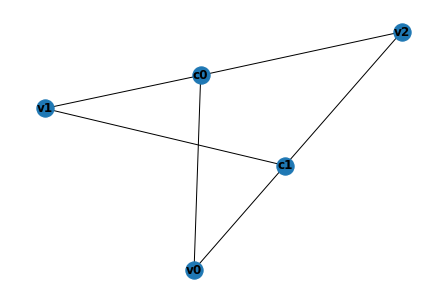

In [126]:
parent_graph = parity_check_mat_to_tanner(np.array([[1,1,1],[1,1,1]]))
nx.draw(parent_graph, with_labels=True, font_weight='bold')
thingie = construct_graph_chain_segment(2)
#thingie.add_edge('v0', 'c10')
#print(thingie.nodes)
#nx.draw(thingie, with_labels=True, font_weight='bold')

[[1.]]
3
The first edge to add is: ('v0', 'c3')
The second edge to add is: ('v3', 'c0')
4
The first edge to add is: ('v0', 'c4')
The second edge to add is: ('v4', 'c1')
5
The first edge to add is: ('v1', 'c5')
The second edge to add is: ('v5', 'c0')
6
The first edge to add is: ('v1', 'c6')
The second edge to add is: ('v6', 'c1')
7
The first edge to add is: ('v2', 'c7')
The second edge to add is: ('v7', 'c0')
8
The first edge to add is: ('v2', 'c8')
The second edge to add is: ('v8', 'c1')
18


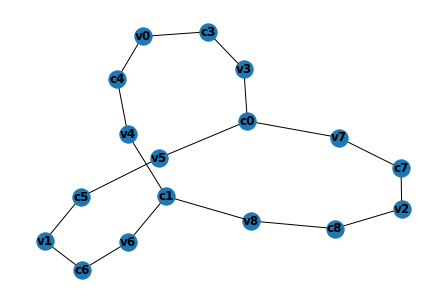

In [128]:
parent_graph = parity_check_mat_to_tanner(np.array([[1,1,1],[1,1,1]]))
#thingie = construct_graph_chain_segment(2)
#print(thingie.nodes)
#thingie_new = relabel_nodes(thingie, parent_graph)
#nx.draw(thingie, with_labels=True, font_weight='bold')
edge_aug_graph = g_augmented_ldpc_code(parent_graph, 1)
print(len(list(edge_aug_graph.edges)))
nx.draw(edge_aug_graph, with_labels=True, font_weight='bold')
#nx.draw(parent_graph, with_labels=True, font_weight='bold')

In [4]:
def prod_code_vars(G: nx.Graph) -> List:
    """ 
    Returns list of variable nodes in product code graph

    Parameters:
    -----------
    G - product code graph
    """
    check_node_list = []
    for tup in list(G.nodes):
        if (tup[0][0] == 'v' and tup[1][0] == 'v') or (tup[0][0] == 'c' and tup[1][0] == 'c'):
            check_node_list.append(tup)
    return check_node_list

def prod_code_checks_X(G: nx.Graph) -> List:
    """ 
    Returns list of check nodes for X checks in product code graph

    Parameters:
    -----------
    G - product code graph
    """
    X_check_var_list = []
    for tup in list(G.nodes):
        if (tup[0][0] == 'c' and tup[1][0] == 'v'):
            X_check_var_list.append(tup)
    return X_check_var_list

def prod_code_checks_Z(G: nx.Graph) -> List:
    """ 
    Returns list of check nodes for Z checks in product code graph

    Parameters:
    -----------
    """
    Z_check_var_list = []
    for tup in list(G.nodes):
        if (tup[0][0] == 'v' and tup[1][0] == 'c'):
            Z_check_var_list.append(tup)
    return Z_check_var_list

def parity_check_mat_X(G: nx.Graph, check_nodes_X: List, var_nodes: List) -> np.array:
    """ 
    Returns the H_X parity-check matrix

    Parameters:
    -----------
    * G - product code graph
    * check_nodes_X - list of check nodes involved in X checks of product code
    * var_nodes - list of variable nodes of Tanner graph of product code 
    """
    num_check_nodes_X = len(check_nodes_X)
    num_var_nodes = len(var_nodes)
    x_mat = np.zeros((num_check_nodes_X, num_var_nodes))
    for i in range(num_check_nodes_X):
        for nbr in nx.neighbors(G, check_nodes_X[i]):
            x_mat[i][var_nodes.index(nbr)] = 1
    return x_mat

def parity_check_mat_Z(G: nx.Graph, check_nodes_Z: List, var_nodes: List) -> np.array:
    """ 
    Returns the H_Z parity-check matrix

    Parameters:
    -----------
    * G - product code graph
    * check_nodes_Z - list of check nodes involved in Z checks of product code
    * var_nodes - list of variable nodes of Tanner graph of product code
    """
    num_check_nodes_Z = len(check_nodes_Z)
    num_var_nodes = len(var_nodes)
    z_mat = np.zeros((num_check_nodes_Z, num_var_nodes))
    for i in range(num_check_nodes_Z):
        for nbr in nx.neighbors(G, check_nodes_Z[i]):
            z_mat[i][var_nodes.index(nbr)] = 1
    return z_mat

def construct_hypergraph_prod_code(pc_mat_1: np.array, pc_mat_2: np.array) -> Tuple:
    """ 
    Constructs hypergraph product code from 2 classical LDPC Code. 

    Parameters:
    -----------
    * pc_mat_1 - 1st parity-check matrix
    * pc_mat_2 - 2nd parity-check matrix

    Returns:
    * (X_pc_mat, Z_pc_mat) - Tuple where 1st element is the X-parity check matrix and 2nd element is the Z-parity check matrix
    """
    tan_graph_1 = parity_check_mat_to_tanner(pc_mat_1)
    tan_graph_2 = parity_check_mat_to_tanner(pc_mat_2)
    prod_code_graph = nx.cartesian_product(tan_graph_1, tan_graph_2)
    var_node_list = prod_code_vars(prod_code_graph)
    X_check_list = prod_code_checks_X(prod_code_graph)
    Z_check_list = prod_code_checks_Z(prod_code_graph)
    X_parity_check_mat = parity_check_mat_X(prod_code_graph, X_check_list, var_node_list)
    Z_parity_check_mat = parity_check_mat_Z(prod_code_graph, Z_check_list, var_node_list)
    return (X_parity_check_mat, Z_parity_check_mat)